# FPL Performance Predictor

We investigate different ways of predicting a players points in a game week.

In [10]:
import os
import math
import itertools
import re
import random
from collections import OrderedDict
from pathlib import Path
import multiprocessing as mp
from datetime import datetime
from IPython.display import display, clear_output
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from loguru import logger
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import Dense, Activation
from sklearn.model_selection import train_test_split
import tensorflow as tf
sns.set(style="white")
%matplotlib inline

In [11]:
os.chdir('../data') 
gws2021_data = 'clean/20_21/gws20_21.pkl'
teams2021_data = 'clean/20_21/teams20_21.pkl'
fixtures2021_data = 'clean/20_21/fixtures20_21.pkl'
gws2122_data = 'clean/21_22/gws21_22.pkl'
teams2122_data = 'clean/21_22/teams21_22.pkl'
fixtures2122_data = 'clean/21_22/fixtures21_22.pkl'

gws2021 = pd.read_pickle(gws2021_data)
teams2021 = pd.read_pickle(teams2021_data)
fixtures2021 = pd.read_pickle(fixtures2021_data)
gws2122 = pd.read_pickle(gws2122_data)
teams2122 = pd.read_pickle(teams2122_data)
fixtures2122 = pd.read_pickle(fixtures2122_data)

gws2021 = gws2021[['gw','name','xP','total_points','value', 'opponent_team']]
gws2021['value'] = gws2021['value']/10
teams2021 = teams2021[['id','strength']].reset_index(drop=True)
teams2021 = teams2021.rename(columns = {'id':'opponent_team', 'strength':'opponent_strength'})
gws2021 = pd.merge(gws2021, teams2021, on='opponent_team')

gws2122 = gws2122[['gw','name','xP','total_points','value', 'opponent_team']]
gws2122['value'] = gws2122['value']/10
teams2122 = teams2122[['id','strength']].reset_index(drop=True)
teams2122 = teams2122.rename(columns = {'id':'opponent_team', 'strength':'opponent_strength'})
gws2122 = pd.merge(gws2122, teams2122, on='opponent_team')

same_players = pd.merge(gws2021, gws2122, on='name')
same_players = same_players['name']
same_players = same_players.drop_duplicates()

gws_plus38 = gws2122
gws_plus38['gw'] = (gws_plus38['gw'] + 38)
gws_plus38 = gws_plus38[gws_plus38['name'].isin(same_players)]
gws_plus38

merged_gws = gws2021[gws2021['name'].isin(same_players)].append(gws_plus38)

merged_gws

C:\Users\phili\AppData\Local\Temp\ipykernel_25940\3159871889.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_gws = gws2021[gws2021['name'].isin(same_players)].append(gws_plus38)


,gw,name,xP,total_points,value,opponent_team,opponent_strength
1,1,Pierre-Emerick Aubameyang,5.0,7.0,12.0,8.0,3
2,1,Cédric Soares,3.1,0.0,5.0,8.0,3
3,1,Alexandre Lacazette,4.0,7.0,8.5,8.0,3
5,1,Bernd Leno,3.5,7.0,5.0,8.0,3
6,1,Granit Xhaka,2.8,3.0,5.5,8.0,3
...,...,...,...,...,...,...,...
14387,67,Gabriel Teodoro Martinelli Silva,6.8,6.0,5.3,9.0,3
14388,67,Ben White,5.2,7.0,4.5,9.0,3
14392,67,Reiss Nelson,0.0,0.0,5.0,9.0,3
14393,67,Martin Ødegaard,6.8,3.0,5.5,9.0,3


In [12]:
merged_gws['score'] = merged_gws['total_points']/merged_gws['xP']
merged_gws.replace([np.inf, -np.inf], 0, inplace=True)

In [13]:
merged_gws

,gw,name,xP,total_points,value,opponent_team,opponent_strength,score
1,1,Pierre-Emerick Aubameyang,5.0,7.0,12.0,8.0,3,1.400000
2,1,Cédric Soares,3.1,0.0,5.0,8.0,3,0.000000
3,1,Alexandre Lacazette,4.0,7.0,8.5,8.0,3,1.750000
5,1,Bernd Leno,3.5,7.0,5.0,8.0,3,2.000000
6,1,Granit Xhaka,2.8,3.0,5.5,8.0,3,1.071429
...,...,...,...,...,...,...,...,...
14387,67,Gabriel Teodoro Martinelli Silva,6.8,6.0,5.3,9.0,3,0.882353
14388,67,Ben White,5.2,7.0,4.5,9.0,3,1.346154
14392,67,Reiss Nelson,0.0,0.0,5.0,9.0,3,NaN
14393,67,Martin Ødegaard,6.8,3.0,5.5,9.0,3,0.441176


# Expected Points

In [14]:
xp = merged_gws
xp['high_points'] = (xp['total_points'] >= 6) * 1
xp['high_xp'] = (xp['xP'] >= 5.5) * 1
print('Accuracy of predicting over 6 points scored when xP >= 5.5: ' + str((xp['high_xp'] == xp['high_points']).sum()/len(xp['high_xp'] == xp['high_points'])))
xp_acc = (xp['high_xp'] == xp['high_points']).sum()/len(xp['high_xp'] == xp['high_points'])
rmse_xp = np.sqrt(mean_squared_error(xp['total_points'].values, xp['xP']))
rmse_xp

xp_acc1 = (xp['xP'] == xp['total_points']).sum()/len(xp['xP'] == xp['total_points'])

Accuracy of predicting over 6 points scored when xP >= 5.5: 0.8700705318724216


# Previous GW points 

In [15]:
pgw = merged_gws
pgw = pgw.groupby(['name','gw']).mean()
pgw['prev_points'] = pgw['total_points']
pgw['prev_points'] = pgw['prev_points'].shift()
pgw['high_prev'] = (pgw['prev_points'] >= 5) * 1
pgw = pgw.dropna()
print('Accuracy of predicting over 6 points scored when previous GW points are 5 or more: ' 
      + str((pgw['high_prev'] == pgw['high_points']).sum()/len(pgw['high_prev'] == pgw['high_points'])))
pgw_acc = (pgw['high_prev'] == pgw['high_points']).sum()/len(pgw['high_prev'] == pgw['high_points'])
rmse_pgw = np.sqrt(mean_squared_error(pgw['total_points'].values, pgw['prev_points']))
rmse_pgw

pgw_acc1 = (pgw['prev_points'] == pgw['total_points']).sum()/len(pgw['prev_points'] == pgw['total_points'])

Accuracy of predicting over 6 points scored when previous GW points are 5 or more: 0.7467051303806777


# Multiple Linear Regression Models
Multiple Linear Regression model that will predict how many points a player will score in a given game week, using opponent strength and previous points as an input.

In [37]:
linear = pgw

x = linear.drop('total_points',axis=1)
x = x[['opponent_strength', 'prev_points']]
y = linear['total_points']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

LR = LinearRegression()

LR.fit(x_train,y_train)

y_prediction =  LR.predict(x_test)
y_prediction = y_prediction.round(decimals = 0)

tester = pd.DataFrame(y_prediction)
print('Accuracy of Points Prediction: ' + str((y_test == y_prediction).sum()/len(y_test)))
rmse_lr = np.sqrt(mean_squared_error(y_test.values, y_prediction))
lr_acc = (y_test == y_prediction).sum()/len(y_test)

Accuracy of Points Prediction: 0.15667420814479638


# Time Series Forecasting ARMA ARIMA

In [19]:
player = 'Trent Alexander-Arnold'
player_name = merged_gws[merged_gws['name'] == player].sort_values(by='gw')
gw_points = player_name
gw_points = gw_points.groupby('gw').sum().reset_index()
gw_points = gw_points.drop(['opponent_team','opponent_strength','value'], axis=1)
gw_info = player_name
gw_info = gw_info.groupby('gw').mean().reset_index()
gw_info = gw_info.drop(['xP','total_points','opponent_team'], axis=1)
player_name = pd.merge(gw_points, gw_info, on='gw')
player_name['score_y'] = player_name['score_y'].fillna(0)

In [20]:
train = player_name[player_name['gw'] <= 60]
test = player_name[player_name['gw'] >60]
train = train[['gw', 'total_points']].set_index('gw')
test = test[['gw', 'total_points']].set_index('gw')

In [21]:
y = train['total_points']
ARMAmodel = SARIMAX(y, order = (1, 0, 72))
ARMAmodel = ARMAmodel.fit()
y_pred = ARMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df['Predictions'] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df['Predictions'] 

C:\Users\phili\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\phili\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\phili\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\phili\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Use

C:\Users\phili\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\phili\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\phili\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\phili\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameter

ARMA RMSE:  5.319842069377219
ARIMA RMSE:  6.166509111326683


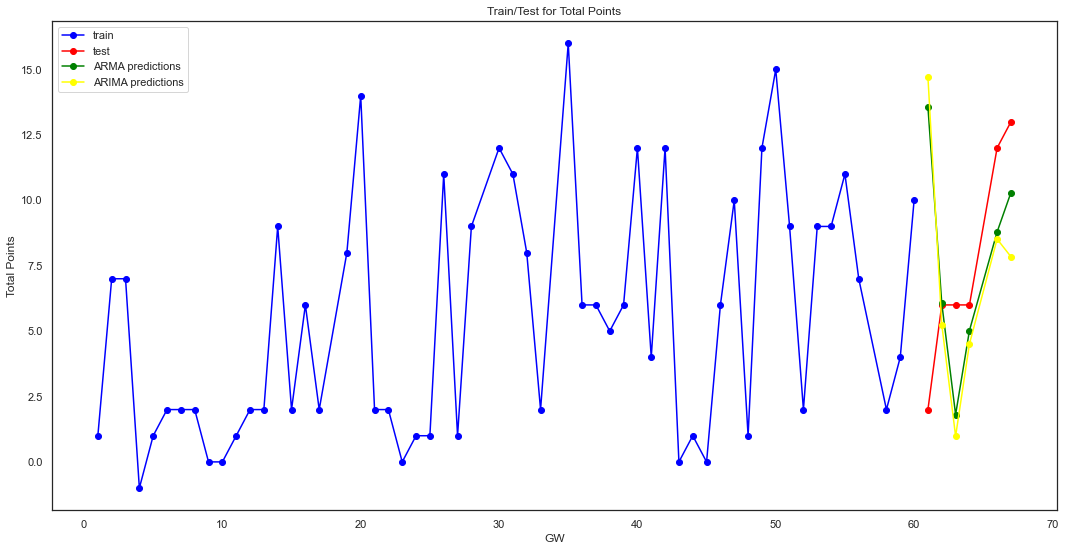

In [22]:
ARIMAmodel = ARIMA(y, order = (4, 0,36))
ARIMAmodel = ARIMAmodel.fit()
arma_rmse = np.sqrt(mean_squared_error(test['total_points'].values, y_pred_df['Predictions']))

ax, fig = plt.subplots(figsize=(18, 9))
plt.plot(train, color = 'blue', label = 'train', marker='o')
plt.plot(test, color = 'red', label = 'test' ,marker='o')
plt.plot(y_pred_out, color='green', label = 'ARMA predictions',marker='o')
y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df['Predictions'] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df['Predictions'] 
plt.ylabel('Total Points')
plt.xlabel('GW')
plt.title('Train/Test for Total Points')
plt.plot(y_pred_out, color='Yellow', label = 'ARIMA predictions',marker='o')
plt.legend()
print('ARMA RMSE: ',arma_rmse)
arima_rmse = np.sqrt(mean_squared_error(test['total_points'].values, y_pred_df['Predictions']))
print('ARIMA RMSE: ',arima_rmse)

Attempt at an ARIMA model, however it was very difficult to set up and fit well.

# Basic Neural Network To Predict High Points
Neural network that will predict if a player will score 6 or more points in a given game week, using opponent strength and previous points as an input.

In [23]:
nn_data = merged_gws
nn_data = nn_data.groupby(['name','gw']).mean()
nn_data['prev_points'] = nn_data['total_points']
nn_data['prev_points'] = nn_data['prev_points'].shift()
nn_data['high_prev'] = (nn_data['prev_points'] >= 5) * 1
nn_data = nn_data.dropna()
nn_data['high_points'] = nn_data['total_points'] >= 6
nn_data['opponent_strength'] = round(nn_data['opponent_strength']) 

In [24]:
x = tf.convert_to_tensor(nn_data[['opponent_strength','high_prev']])
y = nn_data['high_points'].to_numpy()

model = Sequential()
model.add(Dense(2, input_shape=(2,)))

model.compile(loss='mean_squared_error', optimizer='sgd', metrics=['accuracy']) 

model.fit(x, y, epochs=20, batch_size=10000)

Epoch 1/20
2/2 [==============================] - 0s 3ms/step - loss: 0.7993 - accuracy: 0.1576
Epoch 2/20
2/2 [==============================] - 0s 3ms/step - loss: 0.5441 - accuracy: 0.1576
Epoch 3/20
2/2 [==============================] - 0s 2ms/step - loss: 0.3945 - accuracy: 0.1576
Epoch 4/20
2/2 [==============================] - 0s 2ms/step - loss: 0.3068 - accuracy: 0.1576
Epoch 5/20
2/2 [==============================] - 0s 2ms/step - loss: 0.2553 - accuracy: 0.1576
Epoch 6/20
2/2 [==============================] - 0s 2ms/step - loss: 0.2249 - accuracy: 0.1576
Epoch 7/20
2/2 [==============================] - 0s 2ms/step - loss: 0.2070 - accuracy: 0.1576
Epoch 8/20
2/2 [==============================] - 0s 2ms/step - loss: 0.1964 - accuracy: 0.1576
Epoch 9/20
2/2 [==============================] - 0s 2ms/step - loss: 0.1901 - accuracy: 0.1576
Epoch 10/20
2/2 [==============================] - 0s 3ms/step - loss: 0.1862 - accuracy: 0.2097
Epoch 11/20
2/2 [======================

In [25]:
j = tf.convert_to_tensor(nn_data[['xP','high_prev']])
predictions = model.predict(j)
rounded = [round(z[0]) for z in predictions]

In [26]:
nn_acc = (np.array(rounded) == nn_data['high_points']).sum()/len(np.array(rounded) == nn_data['high_points'])
nn_acc

0.8453532439617626

# Basic Neural Network To Predict Exact Points
Neural network that will predict how many points a player will score in a given game week, using opponent strength and previous points as an input.

In [39]:
nn_data = merged_gws
nn_data = nn_data.groupby(['name','gw']).mean()
nn_data['prev_points'] = nn_data['total_points']
nn_data['prev_points'] = nn_data['prev_points'].shift()
nn_data['high_prev'] = (nn_data['prev_points'] >= 5) * 1
nn_data = nn_data.dropna()
nn_data['high_points'] = nn_data['total_points'] >= 6
nn_data['opponent_strength'] = round(nn_data['opponent_strength']) 

x = nn_data.drop('total_points',axis=1)
x = x[['opponent_strength', 'prev_points']]
y = nn_data['total_points']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

x1 = tf.convert_to_tensor(x_train)
y1 = y_train.to_numpy()

model1 = Sequential()
model1.add(Dense(2, input_shape=(2,)))

model1.compile(loss='mean_squared_error', optimizer='sgd', metrics=['accuracy']) 

model1.fit(x1, y1, epochs=20, batch_size=10000)

_,accuracy1 = model1.evaluate(x1, y1)
print('Accuracy: %.2f' % (accuracy1*100))

Epoch 1/20
2/2 [==============================] - 0s 3ms/step - loss: 21.6560 - accuracy: 0.2404
Epoch 2/20
2/2 [==============================] - 0s 2ms/step - loss: 14.1396 - accuracy: 0.3163
Epoch 3/20
2/2 [==============================] - 0s 2ms/step - loss: 11.1518 - accuracy: 0.3120
Epoch 4/20
2/2 [==============================] - 0s 2ms/step - loss: 9.9097 - accuracy: 0.3074
Epoch 5/20
2/2 [==============================] - 0s 1000us/step - loss: 9.3862 - accuracy: 0.2987
Epoch 6/20
2/2 [==============================] - 0s 2ms/step - loss: 9.1358 - accuracy: 0.2961
Epoch 7/20
2/2 [==============================] - 0s 2ms/step - loss: 9.0108 - accuracy: 0.2970
Epoch 8/20
2/2 [==============================] - 0s 2ms/step - loss: 8.9363 - accuracy: 0.2972
Epoch 9/20
2/2 [==============================] - 0s 2ms/step - loss: 8.8836 - accuracy: 0.2972
Epoch 10/20
2/2 [==============================] - 0s 2ms/step - loss: 8.8439 - accuracy: 0.2967
Epoch 11/20
2/2 [================

In [40]:
nn_data

xP  total_points  value  opponent_team  opponent_strength  \
name           gw                                                               
Aaron Connolly 2   4.0           8.0    5.5           14.0                2.0   
               3   2.7           2.0    5.5           13.0                4.0   
               4   2.7           2.0    5.5            7.0                3.0   
               5   3.0           4.0    5.5            6.0                3.0   
               6   2.5           0.0    5.5           18.0                2.0   
...                ...           ...    ...            ...                ...   
Çaglar Söyüncü 64 -0.2           0.0    4.9           20.0                4.0   
               65  2.5           7.0    4.9            5.0                2.0   
               66  3.2           8.0    4.9           10.0                3.0   
               67  3.3           0.0    4.9            1.0                4.0   
               68  2.9           2.0    4.9            3.0                2.0   

                      score  high_points  high_xp  prev_points  high_prev  
name           gw                                                          
Aaron Connolly 2   2.000000         True      0.0          1.0          0  
               3   0.740741        False      0.0          8.0          1  
               4   0.740741        False      0.0          2.0          0  
               5   1.333333        False      0.0          2.0          0  
               6   0.000000        False      0.0          4.0          0  
...                     ...          ...      ...          ...        ...  
Çaglar Söyüncü 64  0.000000        False      0.0          1.0          0  
               65  2.800000         True      0.0          0.0          0  
               66  2.500000         True      0.0          7.0          1  
               67  0.000000        False      0.0          8.0          1  
               68  0.689655        False      0.0          0.0          0  

[17679 rows x 10 columns]

In [41]:
j1 = tf.convert_to_tensor(x_test)
predictions1 = model.predict(j1)
rounded1 = [round(z[0]) for z in predictions1]

In [42]:
nn_acc1 = accuracy1
nn_acc1
rmse_nn_acc1 = np.sqrt(mean_squared_error(rounded1, y_test))

In [43]:
print('Accuracy of Points Prediction: ' + str(accuracy1))
print('RMSE of Neural Network Model: ' + str(np.sqrt(mean_squared_error(rounded1, y_test))))

Accuracy of Points Prediction: 0.2966131567955017
RMSE of Neural Network Model: 5.035701825609361


# Predicting A Player Will Score High Points >=6

In [52]:
os.chdir('../figs') 

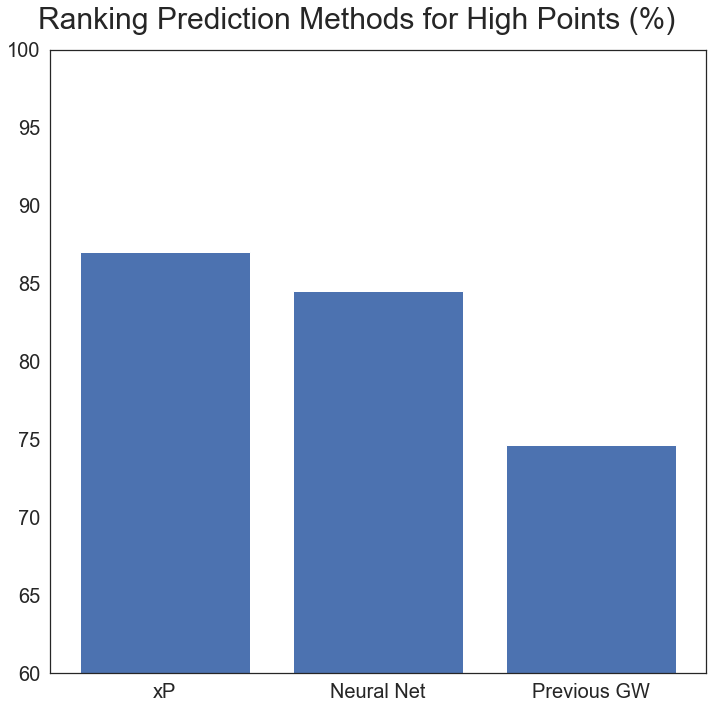

In [56]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.suptitle('Ranking Prediction Methods for High Points (%)', fontsize=30)
xg = ["xP", "Neural Net", "Previous GW"]
yg = [xp_acc*100, nn_acc*100,pgw_acc*100]
plt.bar(xg,yg)
ax.tick_params(labelsize=20)
ax.set_ylim([60,100])
fig.tight_layout()
fig.savefig('prediction_high.png')

xP surprisingly very accurate when predicting high points.

# Predicting Exact Points Scored By a Player

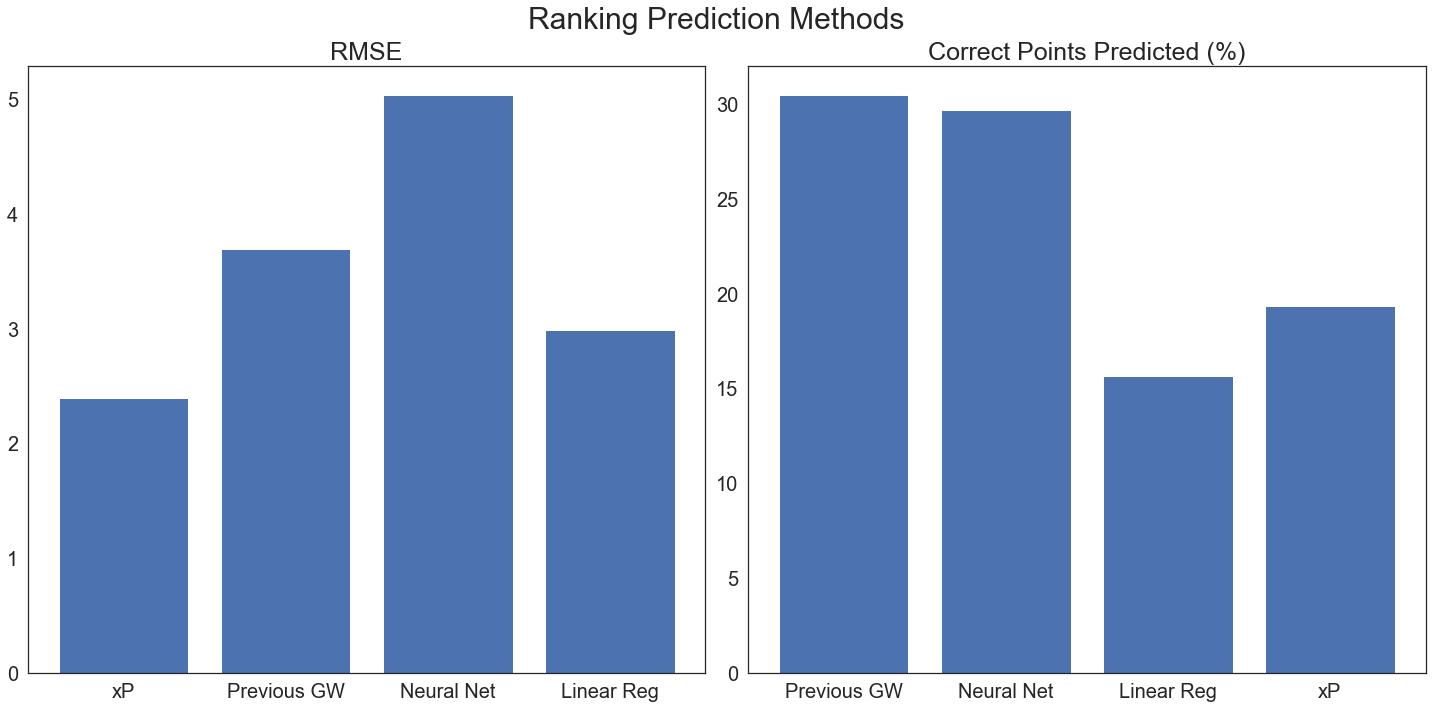

In [45]:
fig, (ax, bx) = plt.subplots(figsize=(20, 10), ncols=2)
plt.suptitle('Ranking Prediction Methods', fontsize=30)
#RMSE
xg1 = ["xP", "Previous GW","Neural Net" , "Linear Reg"]
yg1 = [rmse_xp, rmse_pgw,rmse_nn_acc1,rmse_lr]
ax.bar(xg1,yg1)
ax.set_title('RMSE', fontsize=25)
ax.tick_params(labelsize=20)

#Accuracy
xg2 = ["Previous GW","Neural Net" , "Linear Reg","xP"]
yg2 = [pgw_acc1*100,nn_acc1*100,lr_acc*100,xp_acc1*100]
bx.bar(xg2,yg2)
bx.set_title('Correct Points Predicted (%)',fontsize=25)
bx.tick_params(labelsize=20)

fig.tight_layout()

No real accurate predictions made, however this is likely down to the variance in the data.